# Phenosim disease clustering tutorial
This notebook outlines methods demonstrating how use the `phenosim` library to score and subsequently cluster groups of diseases from three different Phenotypic Series in OMIM.  

To build the groups of diseases, three Phenotypic Series were selected from OMIM.  
1. [Charcot-Marie-Tooth](https://www.omim.org/phenotypicSeries/PS118220)
2. [Spinocerebellar ataxia](https://www.omim.org/phenotypicSeries/PS164400)
3. [Bardet-Biedl syndrome](https://www.omim.org/phenotypicSeries/PS209900)

Each of these Phenotypic Series contains many "sub"-diseases, each with its own unique OMIM identifier. Diseases from the same Phenotypic Sereies generally share many similar phenotypes.  
This tutorial uses the disease-to-phenotype mapping file generated by the HPO as a data source for identifying which HPO ids (phenotypes) are associated with which OMIM ids (diseases). Simple string matching on the name of the Phenotypic Series ("Charcot-Marie-tooth", for example) is used to identify HPO ids associated with each OMIM id in the HPO mapping file.  

The notebook can be run end-to-end as long as your Python enviroment has the plotting libraries `matplotlib` and `seaborn` installed. If these are not installed, you can use `pip install matplotlib` and `pip install seaborn` to install them. 

In [1]:
import os
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from itertools import product
from phenosim.obo import restore
from phenosim.score import Scorer

### Initialize phenosim objects

In [2]:
# restore will only work once an hpo_network.pickle file has been created.
# This file is created by running command-line phenosim at least once.
phenosim_data_directory = os.path.join(os.getenv('HOME'), '.phenosim/data')
hpo = restore(os.path.join(phenosim_data_directory, 'hpo_network.pickle'))
scorer = Scorer(hpo)

### Parse the HPO disease to phenotype file

In [3]:
# Use the HPO's publicly available disease to phenotype mapping file.
disease_phenotype_file = 'http://compbio.charite.de/jenkins/job/hpo.annotations/lastStableBuild/artifact/misc/phenotype_annotation_new.tab'

In [4]:
response = urllib.request.urlopen(disease_phenotype_file)

In [5]:
disease1 = {}
disease2 = {}
disease3 = {}

for line in response:
    try:
        row = line.decode('utf-8').split('\t')
        db = row[0]
        db_object_id = row[1]
        db_name = row[2]
        hpo_id = row[4]
    except IndexError:
        continue
    
    if db == 'OMIM':
        if 'charcot-marie-tooth' in db_name.lower():
            if db_object_id in disease1:
                disease1[db_object_id].append(hpo_id)
            else:
                disease1[db_object_id] = [hpo_id]
        elif 'spinocerebellar ataxia' in db_name.lower():
            if db_object_id in disease2:
                disease2[db_object_id].append(hpo_id)
            else:
                disease2[db_object_id] = [hpo_id]
        elif 'bardet-biedl' in db_name.lower():
            if db_object_id in disease3:
                disease3[db_object_id].append(hpo_id)
            else:
                disease3[db_object_id] = [hpo_id]

In [6]:
print(f'Number of diseases in the CMT series: {len(disease1)}')
print(f'Number of diseases in the SCA series: {len(disease2)}')
print(f'Number of diseases in the BBS series: {len(disease3)}')

Number of diseases in the CMT series: 69
Number of diseases in the SCA series: 74
Number of diseases in the BBS series: 21


In [7]:
# merge the dictionaries
diseases = {**disease1, **disease2, **disease3}

In [8]:
print(f'Number of diseases with both series combined: {len(diseases)}')

Number of diseases with both series combined: 164


### Perform pairwise comparisons of phenotypic similarity for all disease records

In [9]:
def convert_and_filter_hpoids(terms, hpo, scorer):
    """Given a list of HPO ids, first try to convert synonyms to primary ids, 
    then filter if terms are not in the ontology"""
    terms = [scorer.alt2prim[term] if term in scorer.alt2prim else term for term in terms]
    terms = list(filter(lambda term: term in hpo.nodes, terms))
    return terms

In [10]:
records_product = product(diseases.keys(), repeat=2)

### The next two cells show how to run the scoring from the imported library and the command line

1: Using `scorer.score()`

In [11]:
%%time
# score in a simple for-loop, this cell executes in ~2min
results = []
for record1, record2 in records_product:
    terms_1 = convert_and_filter_hpoids(diseases[record1], hpo, scorer)
    terms_2 = convert_and_filter_hpoids(diseases[record2], hpo, scorer)
    results.append((record1, record2, scorer.score(terms_1, terms_2)))

CPU times: user 2min 54s, sys: 953 ms, total: 2min 55s
Wall time: 2min 57s


2: Using the command line tool to score the product of these 

In [12]:
#%%time
#records_product = product(diseases.keys(), repeat=2)
#from subprocess import run
#results = run(["phenosim", "score-product", "../tests/data/test.score-product.txt", "--threads=8"], capture_output=True)

### Plot the pairwise phenotypic similarity results

In [13]:
df = pd.DataFrame(results, columns=['record1', 'record2', 'phenosim-score'])
# convert to square form
df = df.set_index(['record1', 'record2']).unstack()

In [14]:
# get the disease label for each id
colors = {}
color_labels = {
    'r': 'Charcot-Marie-Tooth',
    'b': 'Spinocerebellar Ataxia',
    'g': 'Bardet-Biedl',
}
for omim in df.index:
    if omim in disease1:
        colors[omim] = 'r'
    elif omim in disease2:
        colors[omim] = 'b'
    elif omim in disease3:
        colors[omim] = 'g'

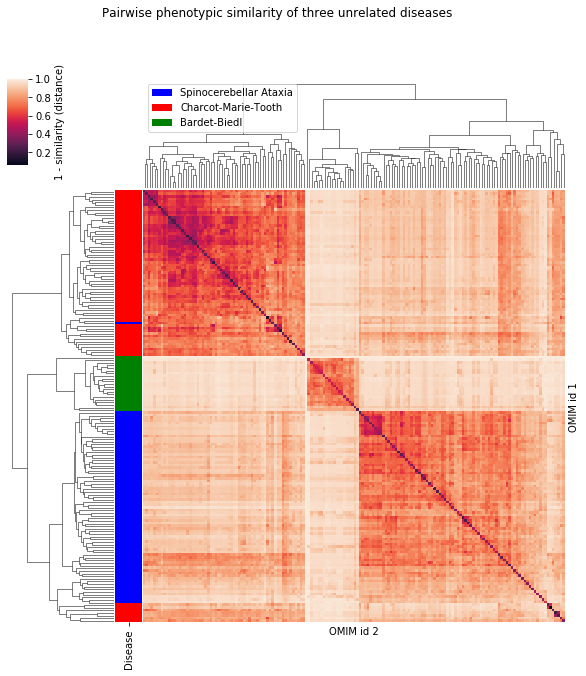

In [15]:
# 1 - df converts the similarity to a distance metric
g = sns.clustermap(1 - df, 
                   row_colors=pd.Series(colors, name="Disease"), 
                   figsize=(10, 10),
                   xticklabels=False, 
                   yticklabels=False,
                   cbar_kws={'label': '1 - similarity (distance)'}
                   
                  )
for label in pd.Series(colors).unique():
    g.ax_col_dendrogram.bar(0, 0, color=label,
                            label=color_labels[label], linewidth=0)

g.ax_heatmap.set_xlabel("OMIM id 2");
g.ax_heatmap.set_ylabel("OMIM id 1");
g.ax_col_dendrogram.legend(loc="upper left");
g.fig.suptitle('Pairwise phenotypic similarity of three unrelated diseases');
plt.savefig('output/cluster_three_diseases.png', format='png');